<a href="https://colab.research.google.com/github/rivalsimatupang/4212211042_AAS-MACHINE-VISION/blob/main/4212211042_RIVAL_SIMATUPANG_jpynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import torch
import numpy as np
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from PIL import Image
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score
from tqdm import tqdm
from mlxtend.plotting import plot_confusion_matrix

In [5]:
 train_data = pd.read_csv('/content/emnist-bymerge-train.csv', header=None, nrows=500)
 test_data = pd.read_csv('/content/emnist-bymerge-test.csv', header=None, nrows=500)

In [6]:
def preprocess_image(data):
    data = np.clip(data, 0, 255).astype(np.uint8).reshape(28, 28)
    return Image.fromarray(data).convert("RGB")

In [7]:
 class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        """
        Initialize the dataset with a DataFrame and optional image transformations.
        """
        self.dataframe = dataframe
        self.transform = transform
    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return len(self.dataframe)
    def __getitem__(self, idx):
        """
        Retrieves the image and label for a given index, applies preprocessing and transformations.
        """
        label = self.dataframe.iloc[idx, 0]
        img_data = self.dataframe.iloc[idx, 1:].values
        image = preprocess_image(img_data)
        if self.transform:
            image = self.transform(image)
        return image, label
    transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
    ])

In [8]:
 # Create datasets and data loaders for training and validation
 # Use train_data and test_data instead of data_train and data_val
 train_dataset = CustomDataset(train_data, transform=CustomDataset.transform)  # Use CustomDataset.transform
 val_dataset = CustomDataset(test_data, transform=CustomDataset.transform)  # Use CustomDataset.transform

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)  # Training data loader
 val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)    # Validation data loader

In [9]:
 # Initialize a pretrained AlexNet model for transfer learning
 model = models.alexnet(pretrained=True)
 model.classifier[6] = nn.Linear(4096, 200)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:03<00:00, 68.2MB/s]


In [10]:
# Freeze feature extraction layers to only train the classifier
for param in model.features.parameters():
    param.requires_grad = False

In [11]:
 # Define loss function and optimizer
 criterion = nn.CrossEntropyLoss()
 optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [12]:
 # Configure the device for GPU acceleration (if available)
 device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
 model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [13]:
 # Training Loop
 from sklearn.model_selection import LeaveOneOut
 from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score

In [14]:
 # Convert the training data into a NumPy array for LOOCV
 data_array = train_data.to_numpy()

In [15]:
# Initialize lists to store predictions and labels for evaluation
all_preds, all_labels = [], []
print("Starting LOOCV...")

Starting LOOCV...


In [16]:
# Leave-One-Out Cross Validation implementation
loo = LeaveOneOut()
for train_idx, test_idx in tqdm(loo.split(data_array)):
    # Split data into training and test sets for this fold
    train_samples = data_array[train_idx]
    test_sample = data_array[test_idx]
    # Create datasets and dataloaders for the current LOOCV split
    train_dataset = CustomDataset(pd.DataFrame(train_samples), transform=CustomDataset.transform)
    test_dataset = CustomDataset(pd.DataFrame(test_sample), transform=CustomDataset.transform)
    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    # Reinitialize the model and optimizer for each LOOCV iteration
    model = models.alexnet(pretrained=True)
    model.classifier[6] = nn.Linear(4096, 200)
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    # Training loop for the current fold
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    # Validation loop for the current fold
    model.eval()
    with torch.no_grad(): # Corrected indentation here
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            all_preds.append(torch.argmax(outputs, dim=1).cpu().item())
            all_labels.append(labels.cpu().item())

500it [35:21,  4.24s/it]


In [17]:
 # Calculate evaluation metrics
 conf_matrix = confusion_matrix(all_labels, all_preds)  # Confusion matrix
 accuracy = accuracy_score(all_labels, all_preds)      # Accuracy score
 precision = precision_score(all_labels, all_preds, average="macro", zero_division=0)  # Precision score
 f1 = f1_score(all_labels, all_preds, average="macro") # F1 score

In [18]:
 # Display evaluation results
 print("\nEvaluation Results:")
 print(f"Confusion Matrix:\n{conf_matrix}")
 print(f"Accuracy: {accuracy:.4f}")
 print(f"Precision: {precision:.4f}")
 print(f"F1-Score: {f1:.4f}")


Evaluation Results:
Confusion Matrix:
[[20  0  0 ...  0  0  0]
 [ 0 15  0 ...  0  0  0]
 [ 1  0 14 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  6  0]
 [ 0  1  0 ...  0  0 11]]
Accuracy: 0.4240
Precision: 0.2080
F1-Score: 0.1978


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

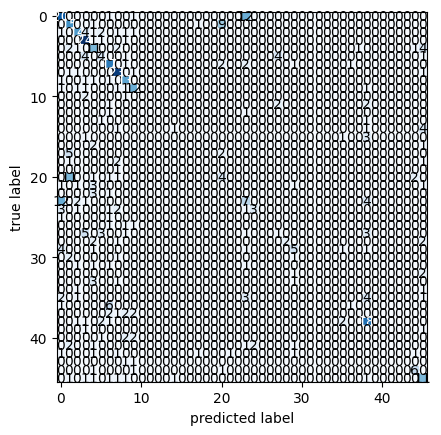

In [21]:
plot_confusion_matrix(conf_matrix)